# pump probe analysis

## initialization

### loading libraries

In [2]:
import sys
import os
path_to_add = "../filter_masks/"
sys.path.append(path_to_add)
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import filter_masks
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from cycler import cycler
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import interactive
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from scipy.interpolate import interp1d
from sklearn.decomposition import FastICA, PCA

In [104]:
# Run this in Python once, it should take effect permanently
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

### setting matplotlib display defaults

In [3]:
#default plot setting
mpl.rcParams['axes.prop_cycle'] = cycler(color='brgcmyk')
mpl.rcParams['figure.figsize'] = (8,8)
plt.rcParams['image.cmap'] = 'magma'
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
#mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10

### loading data

In [4]:



#load data
experiment_run_name = "sxri0414run60"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../small_h5_data/"+my_file,"r")

#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

#no built in type for weighted binnsed statistic, 
#might be able to use sum instead of mean (or average)
def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)
#my_mask *=  (my_dict['ebeam/photon_energy']>913.75)
#my_mask *=  (my_dict['ebeam/photon_energy']<914.25)

#my_mask *=  (my_dict['timeToolOpal/uncertainty_cov']*pixel_to_femtosecond<0.0002)

../filter_masks/filter_masks.py:16: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>1)


## analysis setup

###  setting calibration constants and calibrating time axis

In [5]:
time_tool_sign = 1
pixel_to_femtosecond = 0.0033444
#pixel_to_femtosecond = 0.002
delay_stage_offset = min(my_dict['delayStage'])
my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['timeToolOpal/time_pixel']-mean(my_dict['timeToolOpal/time_pixel'][my_mask]))*pixel_to_femtosecond )

### masking off outliers

In [6]:
#viewing  IvsI0 as function of energy (i.e. photon wavelength).  Are small wavelength fluctuations kill swamping the signal?
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

z = my_dict['corrected_time'][my_mask]
myValues = array([x,y,z,sy]).transpose()
my_bins = arange(-6.0,35,0.185)

fee_difr = my_dict['gas_detector/f_12_ENRC'][my_mask]

my_bins = arange(900,935,0.2)

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

## Linearizing I vs I0 photon energy dependence

### visualizing non-linearity

In [7]:
#generate reference curve
IvsFEE_average = binned_statistic_dd(energy,y,bins=[my_bins],statistic=average).statistic
I0vsFEE_average = binned_statistic_dd(energy,x,bins=[my_bins],statistic=average).statistic

In [8]:
#showing I and I0 are shifted with respect to each other.
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+4e-2
    return a*exp(-(x-x0)**2/(2*sigma**2))
    
#plot(my_bins[:-1],IvsFEE_average)
popt, pcov = curve_fit(gaussian, my_bins[:-1][45:123],IvsFEE_average[45:123],p0=[914,5,1])

#plot(my_bins[:-1],gaussian(my_bins[:-1],popt[0],popt[1],popt[2]))
#twinx()

def gaussian_gmd(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

#plot(my_bins[:-1],I0vsFEE_average,'r')
popt, pcov = curve_fit(gaussian_gmd, my_bins[:-1][45:123],I0vsFEE_average[45:123],p0=[914,5,.0014])

#plot(my_bins[:-1],gaussian_gmd(my_bins[:-1],popt[0],popt[1],popt[2]),c='purple')
#ylim(-0.0000,0.00088)
#show()

In [9]:
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

acq_spectra_amplitude = []
GMD_spectra_amplitude = []



fee_bin_size = .02
fee_bins = arange(0.30,0.7,fee_bin_size)
for i in fee_bins:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee>i
    fee_mask *= fee<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
    
#increment over fee value and generate I and I0 vs photon wavelength
#GMD_spectra_stack = []
#acq_spectra_stack = []

fee_bin_size = .05
fee_bins2 = arange(1.0,1.8,fee_bin_size)
for i in fee_bins2:
    
    fee_mask = ones(len(x)).astype(bool)
    fee_mask *= fee_difr>i
    fee_mask *= fee_difr<i+fee_bin_size
    
    popt = energy[fee_mask],y[fee_mask]
    popt, pcov = curve_fit(gaussian,energy[fee_mask],y[fee_mask],p0=[914,5,1])
    acq_spectra_amplitude.append(popt)
    
    popt, pcov = curve_fit(gaussian_gmd,energy[fee_mask],x[fee_mask],p0=[914,5,.0014])
    GMD_spectra_amplitude.append(popt)
    
fee_bins = append(fee_bins,fee_bins2)
my_slope = theilslopes(abs(array(acq_spectra_amplitude)).transpose()[2],abs(array(GMD_spectra_amplitude).transpose()[2]),alpha=0.95)


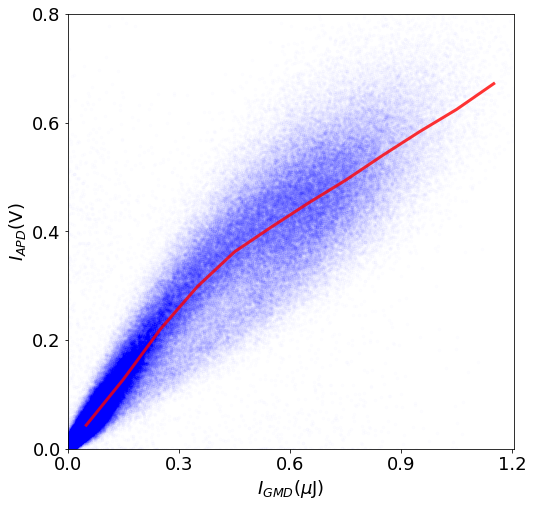

In [10]:
#this show the relationship between I and I0 is more linear after accoutning for different photon energy responses in 
#I and I0
f5, axarr5 = plt.subplots(1, sharex=True)
axarr5.plot(my_dict['GMD'],my_dict['acqiris2/amplitude'],'.',alpha=0.006,markersize=6.0)
#axarr5.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ro',alpha=50)
my_slope= theilslopes(array(acq_spectra_amplitude).transpose()[2],array(GMD_spectra_amplitude).transpose()[2],alpha=0.95)
#axarr5.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'r-',linewidth=2,alpha=50)

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=median).statistic
axarr5.plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=3,alpha=.80,c='r',linestyle='solid')

#I_FEE_hist = binned_statistic_dd(fee,y,bins=[arange(0.05,0.85,0.02)],statistic=mean).statistic
#I0_FEE_hist = binned_statistic_dd(fee,x,bins=[arange(.05,0.85,0.02)],statistic='mean').statistic
#plot(I0_FEE_hist,I_FEE_hist,marker='o',color='purple',linewidth=0)

axarr5.set_xlim(0.000,0.001205)
axarr5.set_xticks(arange(0,.001205,.0003))
axarr5.set_xticklabels(["0.0","0.3","0.6","0.9","1.2"])
axarr5.set_ylim(0,0.8)
axarr5.set_yticks(arange(0,.805,.2))
#axarr5.set_xlabel("I$_0$(mV)")
axarr5.set_xlabel(r"$I_{GMD}$($\mu$J)")
axarr5.set_ylabel("$I_{APD}$(V)")
show()

### the linearization process

In [11]:
energy_x_product = (energy-mean(energy))*(x-mean(x))
energy2_x_product = (energy-mean(energy))**2*(x-mean(x))
fee_energy_gmd_product = (fee-mean(fee))*(x-mean(x))*(energy-mean(energy))
temp_array = array([ones(len(x)),x,energy,energy_x_product]).transpose()
pseudo_inv = dot(inv(dot(temp_array.transpose(),temp_array)),array(temp_array).transpose())
beta = dot(pseudo_inv,y-mean(y))

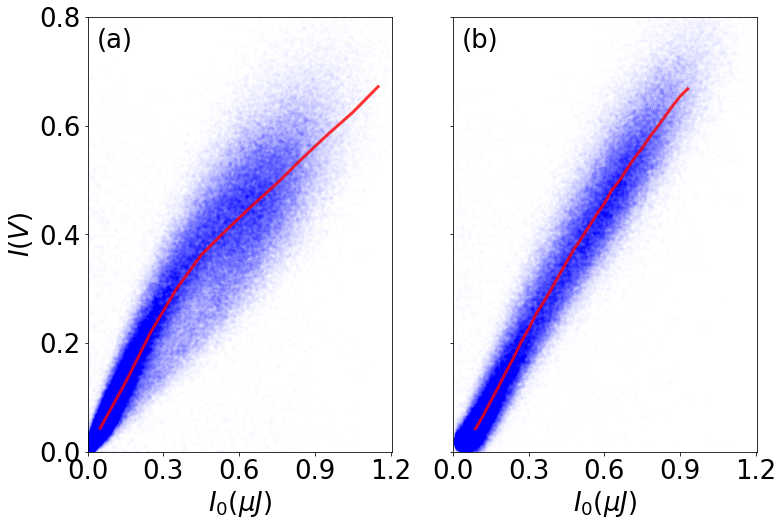

In [12]:
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 26
mpl.rcParams['legend.fontsize'] = 16
x = my_dict['GMD'][my_mask]

x_label_offset = 0.15
y_label_offset = 0.925

#y = my_dict['acqiris2/amplitude'][my_mask]
#sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
#energy = my_dict['ebeam/photon_energy'][my_mask]
#fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

#y_corrected = y-dot(temp_array[:,2:],beta[2:])-temp_array[:,0]*beta[0]-mean(y)
y_corrected = y-dot(temp_array[:,2:]-mean(temp_array[:,2:],axis=0),beta[2:])

f5, axarr5 = plt.subplots(1,2,sharey=True)
axarr5[1].plot(x,y_corrected,'.',alpha=0.006,markersize=6.0)

x_linear = arange(0.000075,0.00095,0.00003)
my_hist_linear = binned_statistic_dd(x,y_corrected,bins=[x_linear],statistic=median).statistic
#axarr5[1].plot(x_linear,(x_linear)*beta[1],linewidth=3,alpha=.80,c='r',linestyle='solid')
axarr5[1].plot((x_linear[1:]+x_linear[:-1])/2,my_hist_linear,linewidth=3,alpha=.80,c='r',linestyle='solid')
axarr5[1].set_xlim(0.000,0.001205)
axarr5[1].set_ylim(0,max(y_corrected))


axarr5[0].plot(my_dict['GMD'],my_dict['acqiris2/amplitude'],'.',alpha=0.006,markersize=6.0)
#axarr5.plot(array(GMD_spectra_amplitude).transpose()[2],array(acq_spectra_amplitude).transpose()[2],'ro',alpha=50)
my_slope= theilslopes(array(acq_spectra_amplitude).transpose()[2],array(GMD_spectra_amplitude).transpose()[2],alpha=0.95)
#axarr5.plot(arange(0,0.0015,.0001),my_slope[0]*arange(0,0.0015,.0001)+my_slope[1],'r-',linewidth=2,alpha=50)

my_hist = binned_statistic_dd(x,y,bins=[arange(0,0.0014,0.0001)],statistic=median).statistic
axarr5[0].plot((arange(0,0.0014,0.0001)[1:]+arange(0,0.0014,0.0001)[:-1])/2,my_hist,linewidth=3,alpha=.80,c='r',linestyle='solid')
axarr5[0].text(x_label_offset, 0.975, "(a)", transform=axarr5[0].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')
axarr5[1].text(x_label_offset, 0.975, "(b)", transform=axarr5[1].transAxes,fontsize=26, fontweight='normal', va='top', ha='right')

for i in range(2):
    axarr5[i].set_xlim(0.000,0.001205)
    axarr5[i].set_xticks(arange(0,.001205,.0003))
    axarr5[i].set_xticklabels(["0.0","0.3","0.6","0.9","1.2"])
    axarr5[i].set_xlabel(r"$I_{0}$($\mu J$)")

axarr5[0].set_ylim(0,0.8)
axarr5[0].set_yticks(arange(0,.805,.2))
#axarr5.set_xlabel("I$_0$(mV)")
axarr5[0].set_ylabel(r"$I(V)$")

show()

mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 10


### pump probe analysis using fixed gmd vs energy slope

In [88]:
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)



#my_mask = my_mask * (0.0003<my_dict['GMD'])
x = my_dict['GMD'][my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
energy = my_dict['ebeam/photon_energy'][my_mask]
fee = my_dict['gas_detector/f_22_ENRC'][my_mask]

z = my_dict['corrected_time'][my_mask]
myValues = array([x,y,z,sy,energy]).transpose()


energy_x_product = (energy-mean(energy))*(x-mean(x))
temp_array = array([ones(len(x)),x,energy,energy_x_product]).transpose()
y_corrected = y-dot(temp_array[:,2:]-mean(temp_array[:,2:],axis=0),beta[2:])
################
################
################
#this value keeps getting tweaked. how to optimize?
bin_step=0.075

################
################
################

my_bins = arange(-6.0,35,bin_step)

../filter_masks/filter_masks.py:16: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>1)


In [89]:
X_m = array([ones(len(x)),x]).transpose()
dot(dot(inv(dot(X_m.transpose(),X_m)),X_m.transpose()),y)
X_m.shape

(182263, 2)

In [126]:
def get_slope(i):

    temp_mask = z>my_bins[i]
    temp_mask = temp_mask *( z<my_bins[i+1])

    Xp_m = 0+X_m[temp_mask]
    yp_corrected = y_corrected[temp_mask]
    try:
        return dot(dot(inv(dot(Xp_m.transpose(),Xp_m)),Xp_m.transpose()),yp_corrected)

    except (KeyboardInterrupt,TypeError,IndexError,LinAlgError,ValueError):
        return zeros([X_m.shape[1]])
    

In [128]:
time_trace = array([get_slope(i) for i in arange(len(my_bins)-4)])

#### the pump probe trace

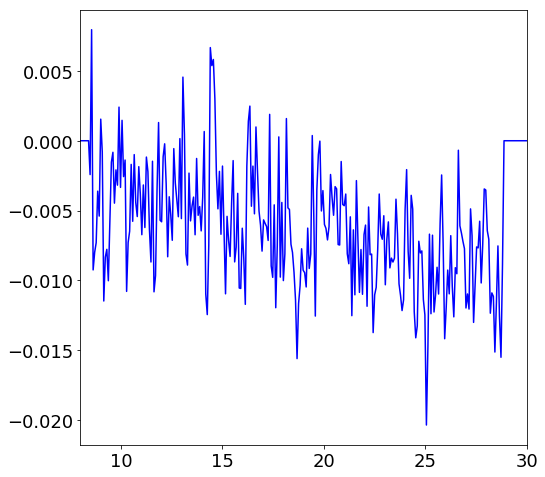

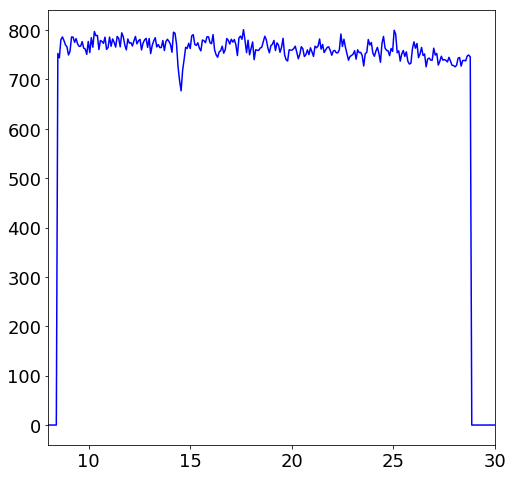

In [130]:
for i in arange(time_trace.shape[1]):
    plot(my_bins[:-4],time_trace[:,i][::-1])
    #ylim(450,1050)
    xlim(8,30)
    show()


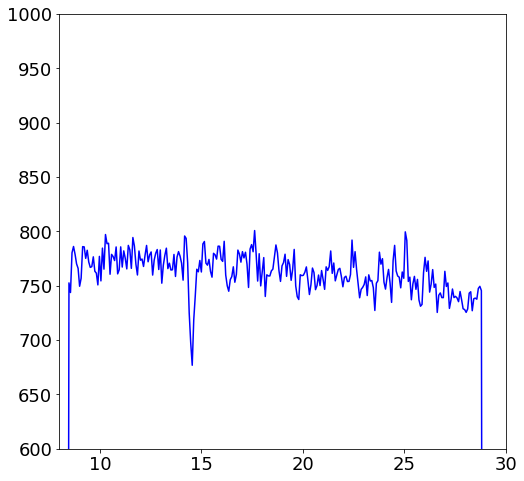

In [137]:
plot(my_bins[:-4],time_trace[:,i][::-1])
#ylim(450,1050)
xlim(8,30)
ylim(600,1000)
show()

## fitting apd vs both energy and gmd using RANSAC

In [21]:
X_m = array([x,energy,(x-mean(x))*(energy-mean(energy))]).transpose()

In [22]:
X_m.shape

(173425, 3)

In [23]:
ransac = linear_model.RANSACRegressor()
ransac.fit(rand(100,2),rand(100))

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_metric=None,
        residual_threshold=None, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

In [24]:
def get_ransac(i):
    try:
        temp_mask = z>my_bins[i]
        temp_mask = temp_mask*(z<my_bins[i+1])
        ransac = linear_model.RANSACRegressor(max_trials=1000)
        ransac.fit(X_m[temp_mask],y[temp_mask])
    except:
        ransac.fit(rand(100,3),rand(100))

    return ransac

In [25]:
pump_probe_trace = array([get_ransac(i) for i in arange(len(my_bins)-1)])
pump_probe_trace_coef = array([pump_probe_trace[i].estimator_.coef_ for i in arange(len(pump_probe_trace))])

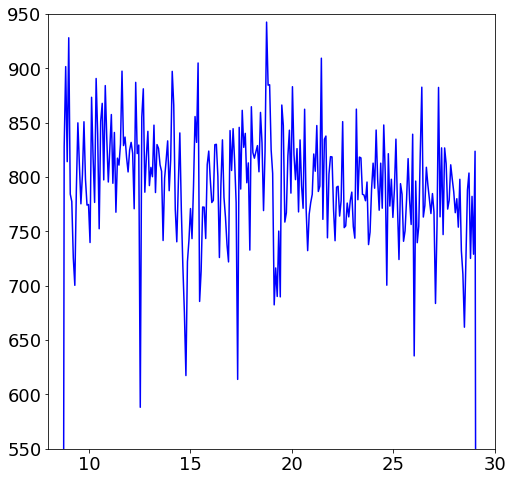

In [26]:
plot(my_bins[:-1][::-1],pump_probe_trace_coef[:,0])
xlim(8,30)
ylim(550,950)
show()

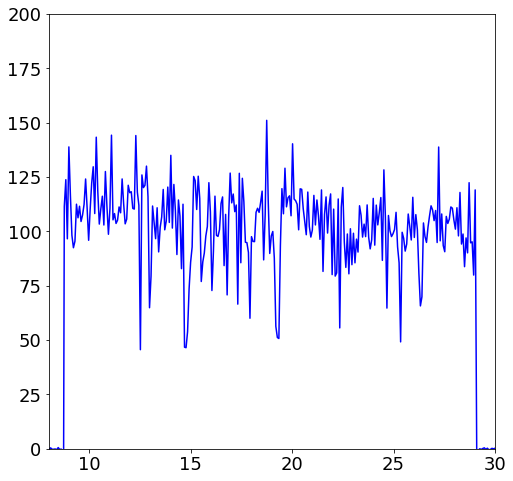

In [27]:
plot(my_bins[:-1][::-1],pump_probe_trace_coef[:,2])
xlim(8,30)
ylim(0,200)
show()

## fitting apd vs both energy and gmd using multi-dimensional theil-sen 

In [87]:
X_m = array([ones(len(x)),x,z]).transpose()

In [88]:
def get_theilsen(i):
    try:
        temp_mask = z>my_bins[i]
        temp_mask = temp_mask*(z<my_bins[i+1])
        estimator =  TheilSenRegressor()
        estimator.fit(X_m[temp_mask],y[temp_mask])
    except:
        estimator.fit(rand(100,X_m.shape[1]),rand(100))

    return estimator

In [89]:
try:
    pump_probe_trace = array([get_theilsen(i) for i in arange(len(my_bins)-1)])
except KeyboardInterrupt:
    pass

In [93]:
pump_probe_trace_coef = array([pump_probe_trace[i].coef_ for i in arange(len(pump_probe_trace))])

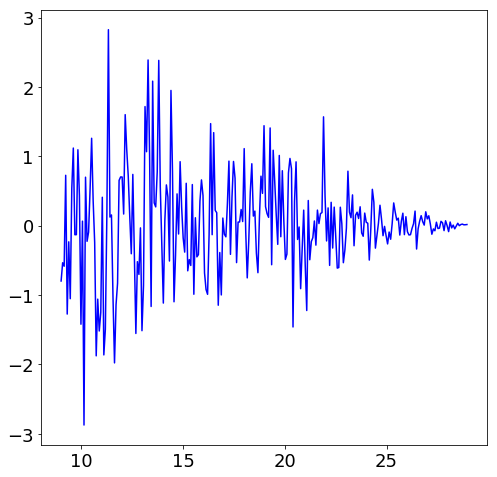

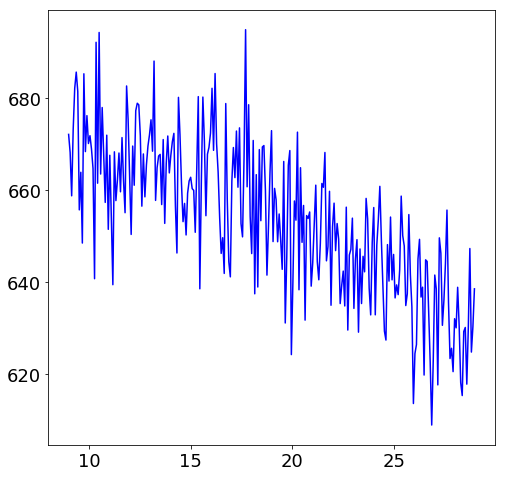

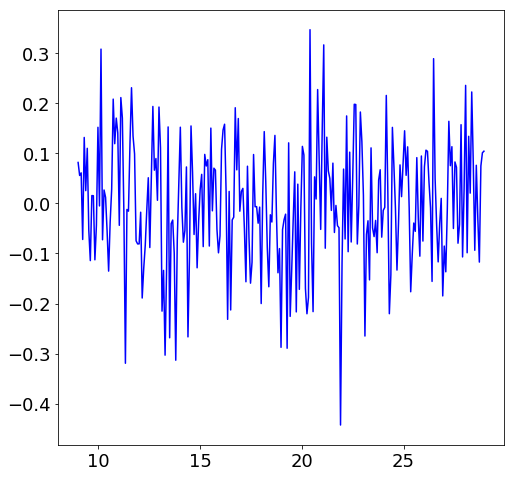

In [98]:
correct_time_bin = my_bins[:-1][::-1]
my_mask = correct_time_bin>9
my_mask = my_mask*(correct_time_bin<29)
for i in arange(pump_probe_trace_coef.shape[1]):
   

    plot(correct_time_bin[my_mask],pump_probe_trace_coef[:,i][my_mask])
    show()

## SVD of EDF

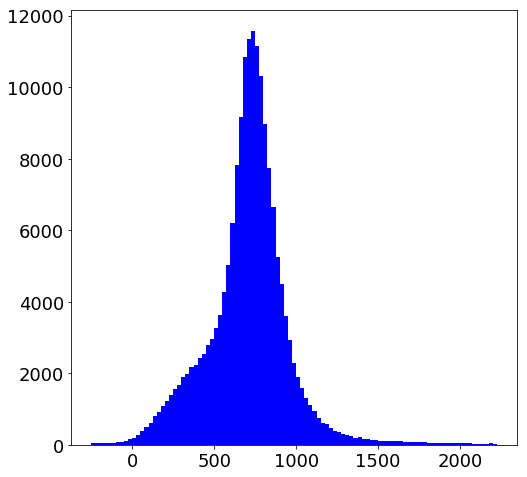

In [182]:
hist(y_corrected/x,bins = arange(-250,2250,25))
show()

In [312]:
################
################
################
#this value keeps getting tweaked. how to optimize?
bin_step=0.025

################
################
################

my_bins = arange(-6.0,35,bin_step)

In [313]:
pump_probe_trace = binned_statistic_dd(z,nan_to_num(y_corrected/x),bins =[my_bins],statistic=median)

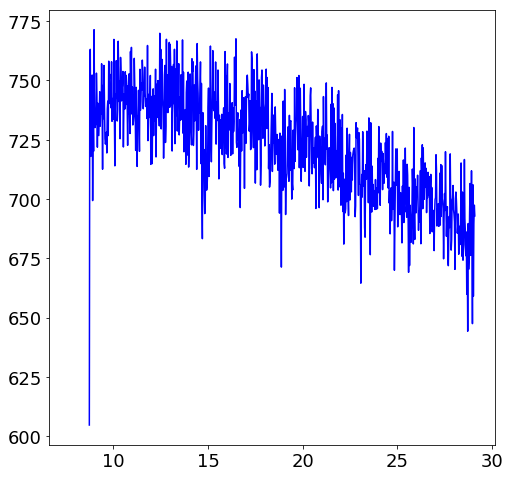

In [314]:
plot(my_bins[:-1][::-1],pump_probe_trace.statistic)
show()

In [315]:
x_dummy = x.copy()
y_dummy = y.copy()
alpha = y_corrected/x
max_alpha = max(alpha)
min_alpha = min(alpha)

def make_edf(my_mask,remove_offset = False):

    if remove_offset:
        my_slope = theilslopes(y_dummy[my_mask],x_dummy[my_mask],alpha=0.95)
        
        alpha = (y_dummy-1.0*my_slope[1])/x_dummy
        
    else:
        alpha = y_corrected/x_dummy
    
    y = alpha[my_mask]
    x = append(min_alpha,append(y,max_alpha))
    my_edf = []
    my_edf.append(sort(x))
    temp_edf = cumsum(argsort(x))
    temp_edf = temp_edf/temp_edf[-1]
    my_edf.append(temp_edf )
    return array(my_edf)

def make_theilsen_edf(my_mask):    
    my_slopes = [-1e6]
    for i in arange(sum(my_mask)):
        for j in arange(sum(my_mask)):
            if(i !=j):
                this_slope = (y_corrected[my_mask][i]-y_corrected[my_mask][j])/(x[my_mask][i]-x[my_mask][j])
                my_slopes.append(this_slope)
    
    my_slopes.append(1e6)
    temp = array(my_slopes)
    my_edf = []

    my_edf.append(sort(my_slopes))
    temp_edf = cumsum(argsort(my_slopes))
    temp_edf = temp_edf/temp_edf[-1]
    my_edf.append(temp_edf )
    
    return array(my_edf)

In [316]:
temp_mask = array([False for i in arange(len(x))])
temp_mask[2000:3000]=True
my_edf = make_edf(temp_mask,remove_offset=True)

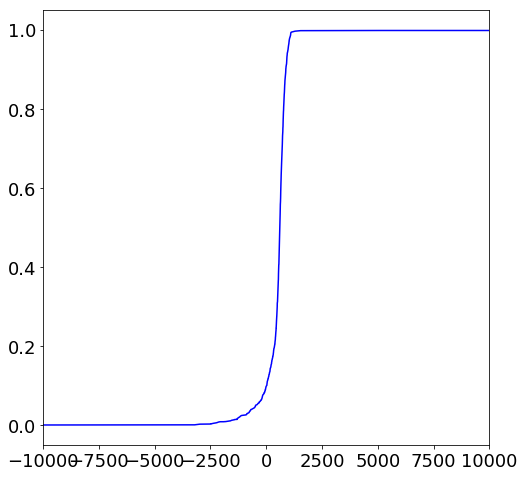

In [317]:
plot(my_edf[0],my_edf[1])
xlim(-10000,10000)
show()

In [318]:
def make_edf_dot(i,j,recenter=False,mean_subtraction=False):
    i_mask = z>my_bins[i]
    i_mask = i_mask *( z<my_bins[i+1])
    
    j_mask = z>my_bins[j]
    j_mask = j_mask *( z<my_bins[j+1])
    
  
    edf_i = make_edf(i_mask)
    edf_j = make_edf(j_mask)
    
    if(recenter):
        edf_i[0] -= edf_i[0][int(len(edf_i[0])/2)]
        edf_j[0] -= edf_j[0][int(len(edf_j[0])/2)]
        
    if(mean_subtraction):
        edf_i[1]-=0.5
        edf_j[1]-=0.5
    
    f = interp1d(edf_j[0],edf_j[1],kind='nearest',bounds_error=False,fill_value=(0,1))
    edf_j_interp = f(edf_i[0])
    
    return dot(edf_j_interp,edf_i[1])

def make_edf_matrix(i,j,recenter=False,mean_subtraction=False):
    i_mask = z>my_bins[i]
    i_mask = i_mask *( z<my_bins[i+1])
    
    j_mask = z>my_bins[j]
    j_mask = j_mask *( z<my_bins[j+1])
    
  
    edf_i = make_edf(i_mask)
    edf_j = make_edf(j_mask)
    
    if(recenter):
        edf_i[0] -= edf_i[0][int(len(edf_i[0])/2)]
        edf_j[0] -= edf_j[0][int(len(edf_j[0])/2)]
        
    if(mean_subtraction):
        edf_i[1]-=0.5
        edf_j[1]-=0.5
    
    f = interp1d(edf_j[0],edf_j[1],kind='nearest',bounds_error=False,fill_value=(0,1))
    edf_j_interp = f(arange(-10000,10000,100))
    
    return edf_j_interp
    

In [319]:
x_start,x_end = 85,340
my_edf_matrix = []
for i in arange(x_start,x_end):
    my_edf_matrix.append(make_edf_matrix(0,i))

my_edf_matrix = array(my_edf_matrix)
my_pdf_matrix = diff(my_edf_matrix,axis=1)
u,s,v = svd(my_pdf_matrix )

In [ ]:
force_symmetry = False
my_matrx = zeros([len(my_bins),len(my_bins)])
for i in arange(len(my_bins)-1):
    try:
        if(i%25==1): 
            print(i)

        if(force_symmetry):
            for j in arange(i+1):
                #if(j%25==0):
                    #print("j = "+str(j))
                my_matrx[i,j] = make_edf_dot(i,j,recenter=False,mean_subtraction=True)
        else:
            for j in arange(len(my_bins)-1):
                my_matrx[i,j] = make_edf_dot(i,j,recenter=False,mean_subtraction=True)
    except KeyboardInterrupt:
        break

1
26
51
76
101
126
151
176
201
226
251
276
301
326
351
376
401
426
451
476
501
526
551
576
601
626
651
676
701
726
751
776
801
826


In [191]:
my_matrx = (my_matrx+my_matrx.transpose())/2.0

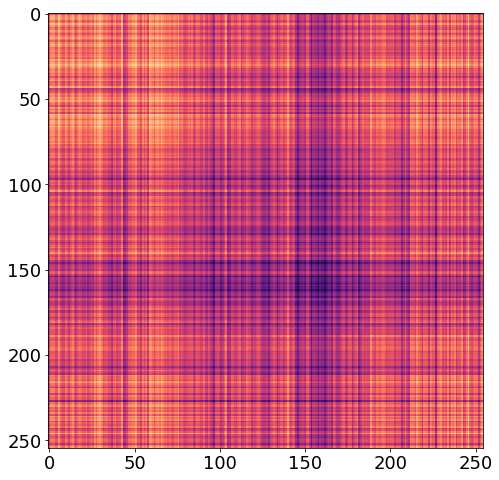

In [192]:
x_start,x_end = 85,340
    
imshow(my_matrx[x_start:x_end ,x_start:x_end ])
show()

In [193]:
eig_val, eig_vec = eig(my_matrx[x_start:x_end,x_start:x_end])

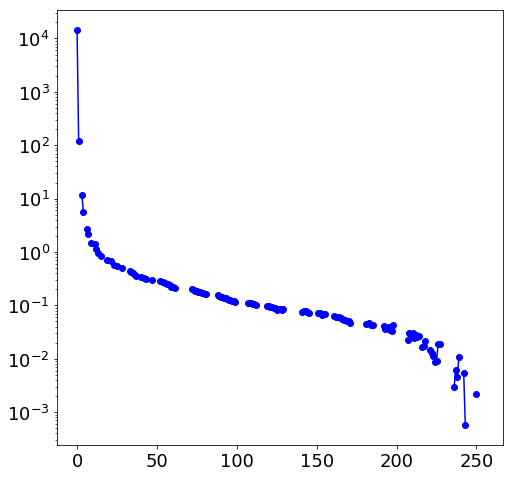

In [194]:
semilogy(real(eig_val),marker='o')
show()

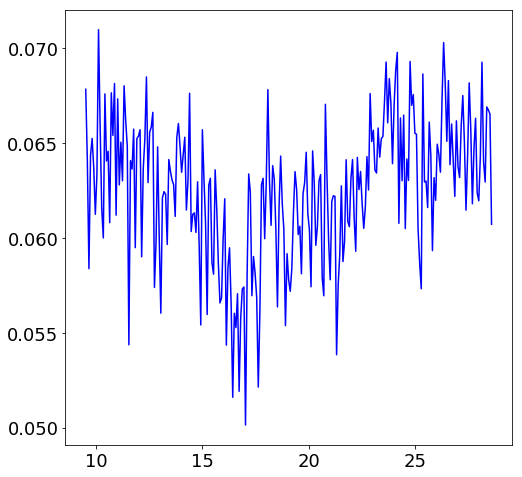

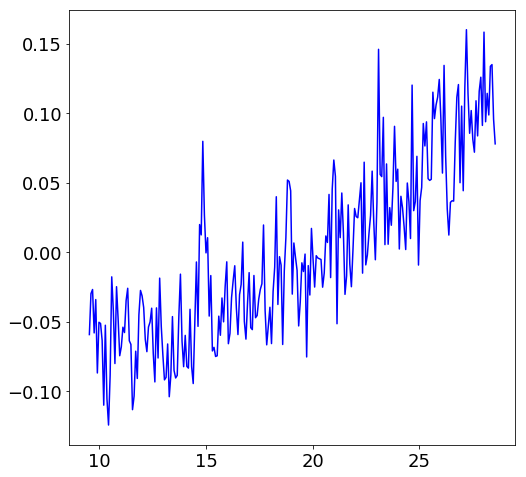

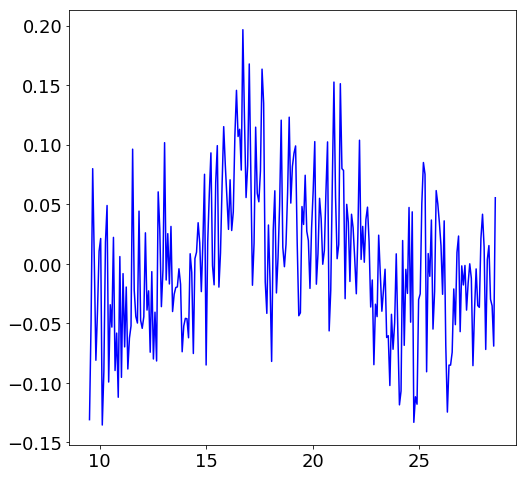

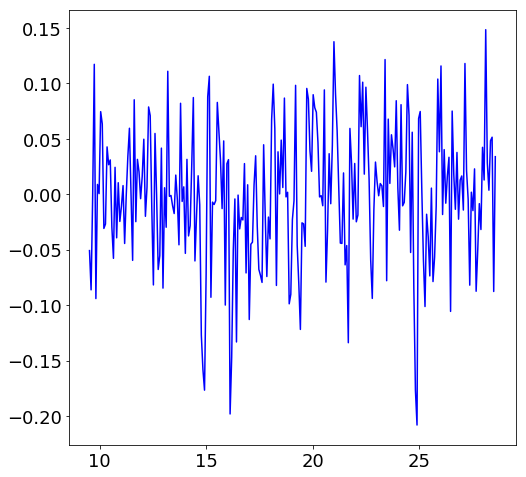

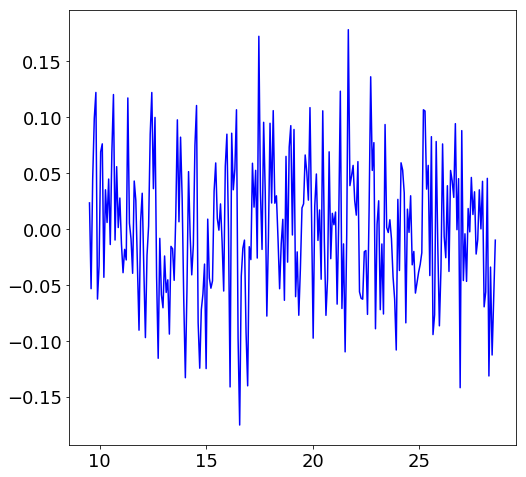

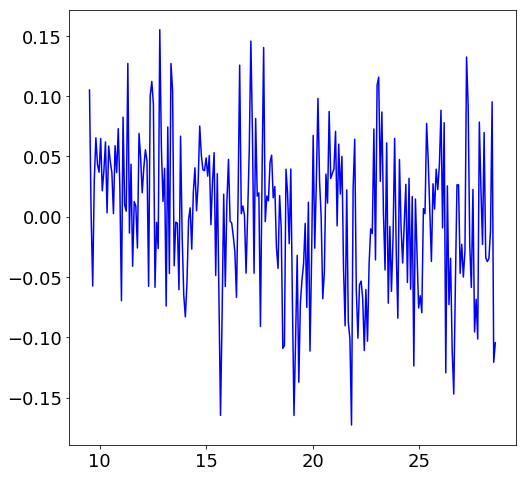

In [198]:
for i in arange(6):
    plot(my_bins[::-1][x_start:x_end],real(eig_vec[:,i]))
    show()

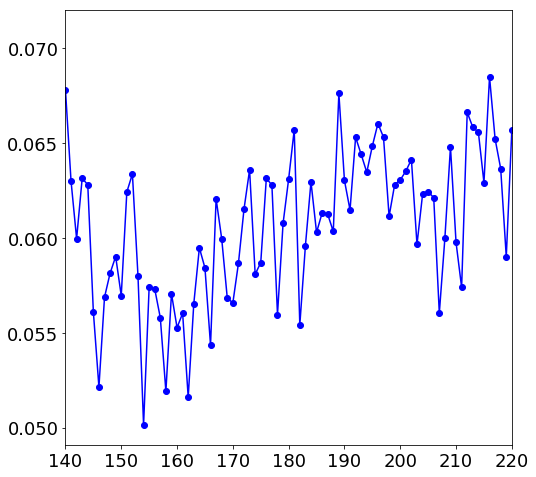

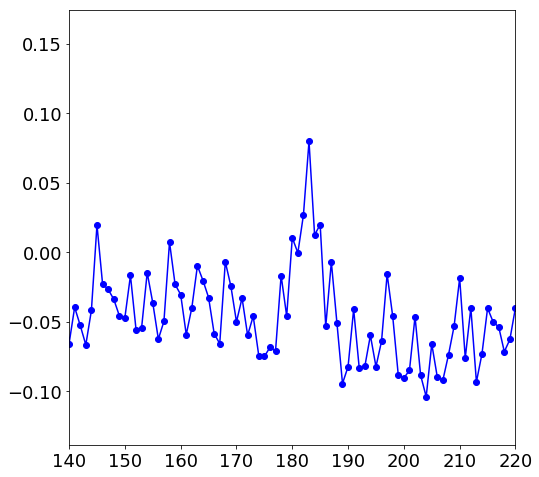

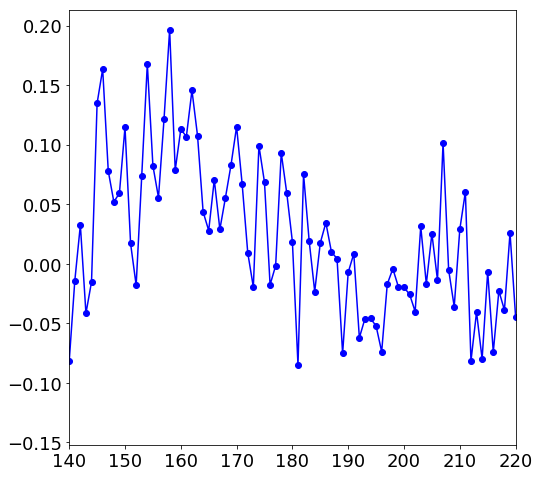

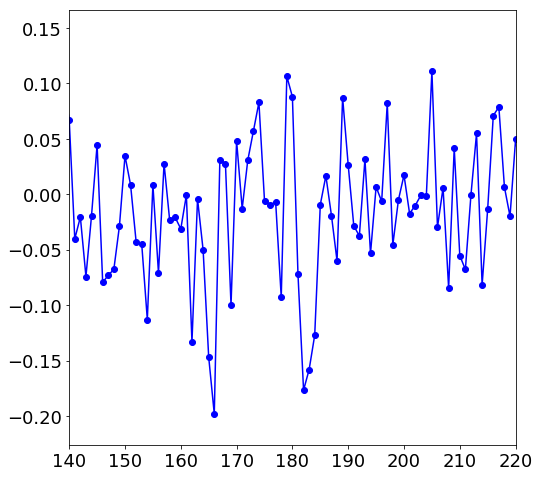

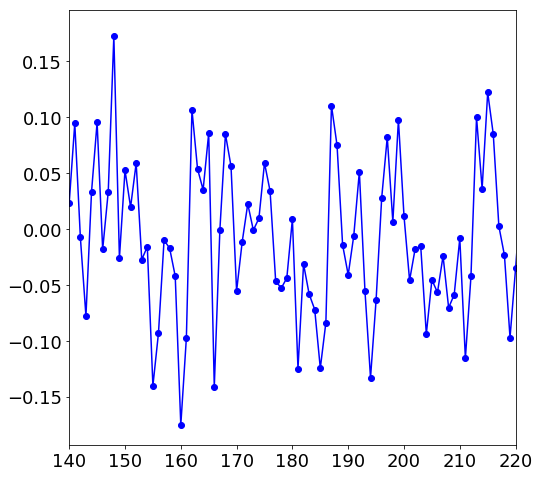

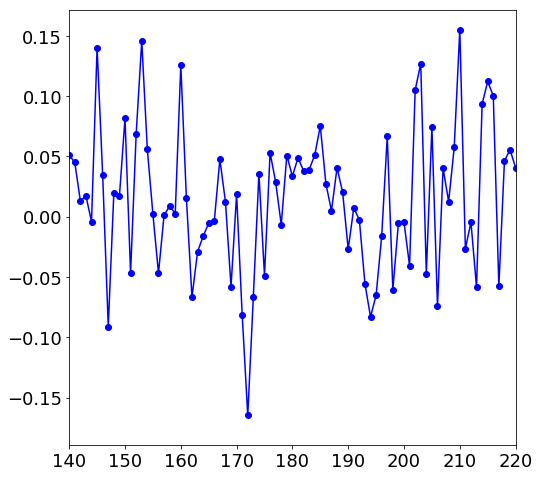

In [311]:
for i in arange(6):
    plot(real(eig_vec[:,i]),marker='o')
    xlim(140,220)
    show()

In [207]:
eig_vec.shape

(255, 255)

In [264]:
n_coefs = 10
flat_region = 200
my_coefs = dot(dot(inv(dot(eig_vec[flat_region:,0:n_coefs].transpose(),eig_vec[flat_region:,0:n_coefs])),eig_vec[flat_region:,0:n_coefs].transpose()),ones(255-flat_region))

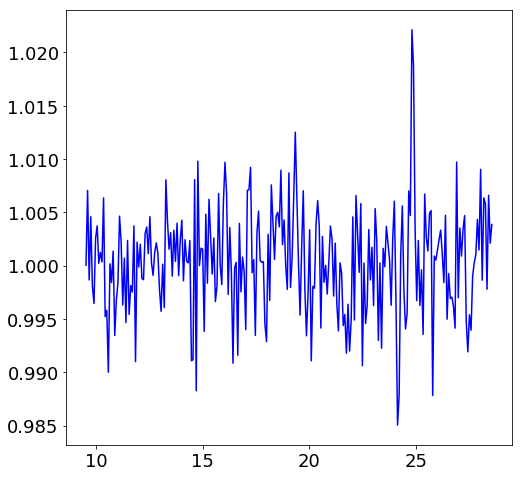

In [265]:
plot(my_bins[::-1][x_start:x_end],dot(eig_vec[:,0:n_coefs],my_coefs))
show()

/home/mouth_breather/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


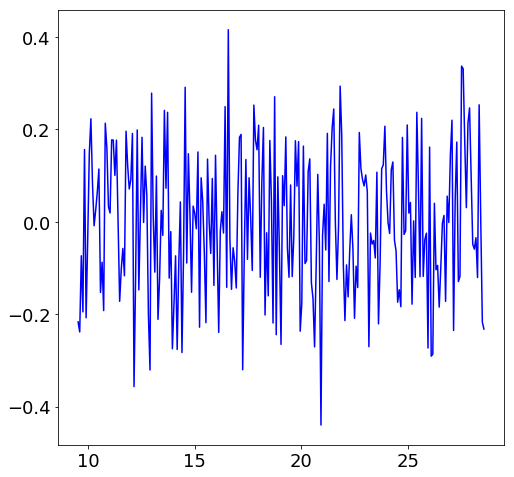

In [308]:
n_coefs = 200
zeros_region = 20
eig_ft = (fft(eig_vec,axis=0))
roll_off = zeros(255)
roll_off[:zeros_region] = 1
roll_off[-zeros_region:] = 1
my_coefs = dot(dot(inv(dot(eig_ft[:,0:n_coefs].transpose(),eig_ft[:,0:n_coefs])),eig_ft[:,0:n_coefs].transpose()),roll_off)
plot(my_bins[::-1][x_start:x_end],-dot(eig_vec[:,0:n_coefs],my_coefs))
show()
#eig_ft

In [196]:
n_components = 3
ica = FastICA(n_components=n_components,max_iter=100000)
S_ = ica.fit_transform(real(eig_vec[:4].transpose())) # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

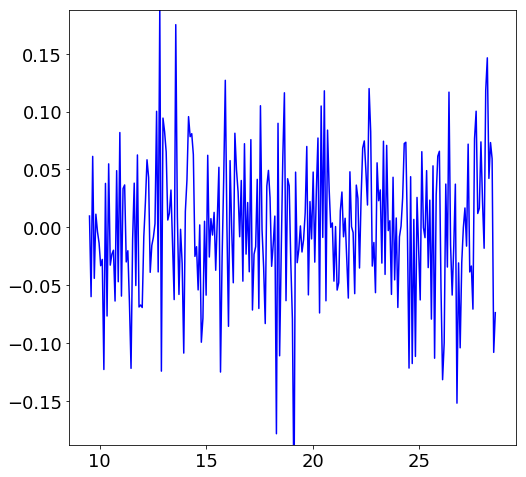

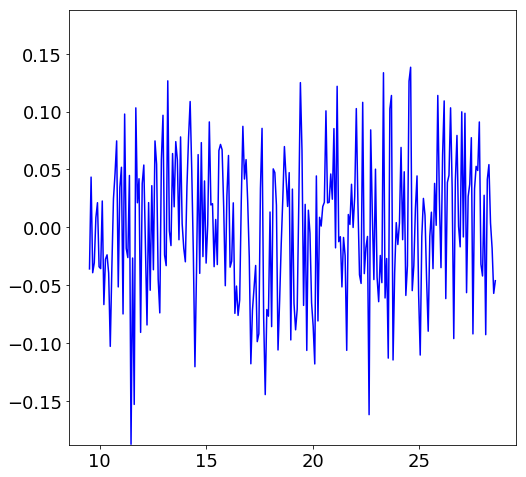

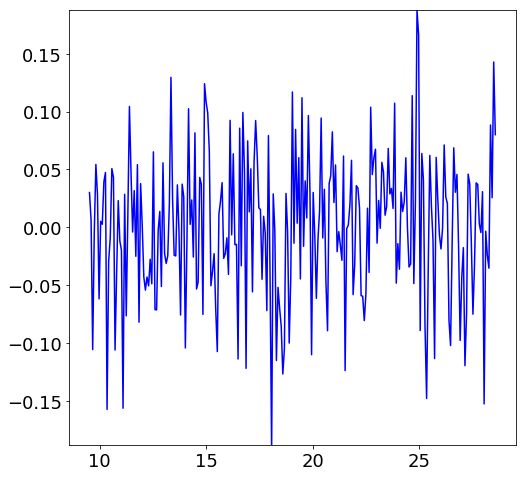

In [197]:
for i in arange(n_components):
    plot(my_bins[::-1][x_start:x_end],S_[:,i])
    my_std = std(S_[:,i])
    ylim(-3*my_std,3*my_std)
    show()

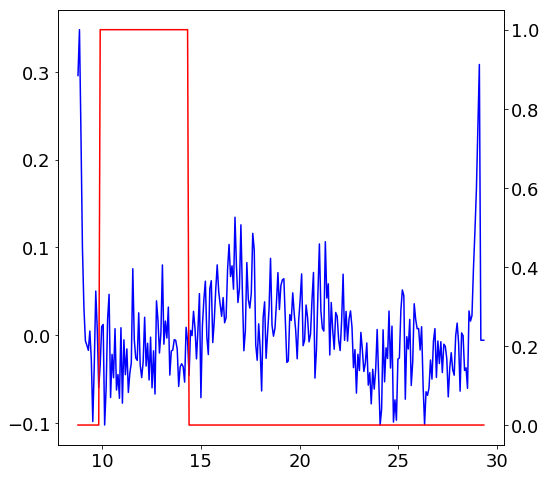

In [40]:
to_fit = zeros(real(eig_vec.shape[0]))
fit_start,fit_end = 200,260
to_fit[fit_start:fit_end] = 1.0
plot(my_bins[::-1][x_start:x_end],-real(eig_vec[:,2]))
twinx()
plot(my_bins[::-1][x_start:x_end],to_fit,'r')
show()

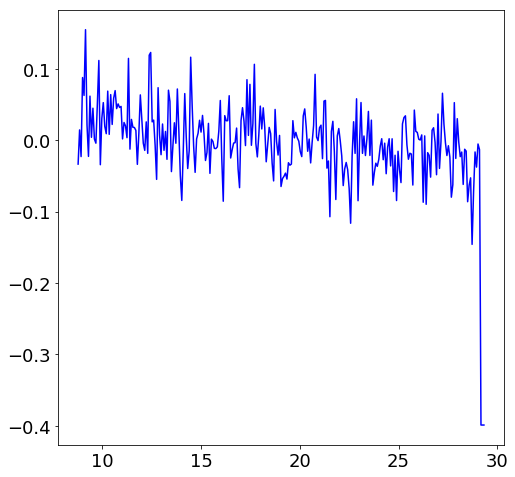

In [41]:
plot(my_bins[::-1][x_start:x_end],-real(eig_vec[:,4]))
show()

In [542]:
my_pinv = dot(inv(dot(eig_vec[:,fit_start:fit_end].transpose(),eig_vec[:,fit_start:fit_end])),eig_vec[:,fit_start:fit_end].transpose())

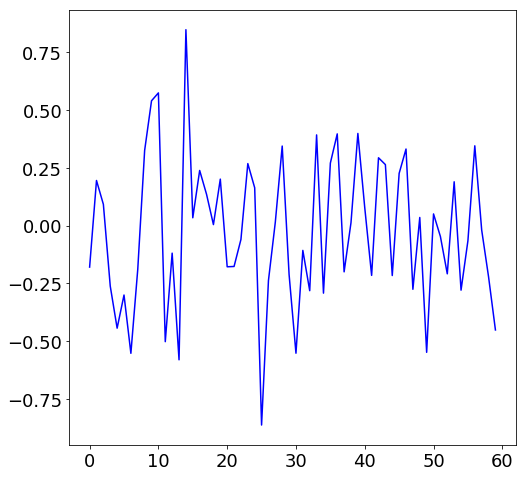

In [543]:
my_coefs = dot(my_pinv,to_fit)
plot(my_coefs)
show()

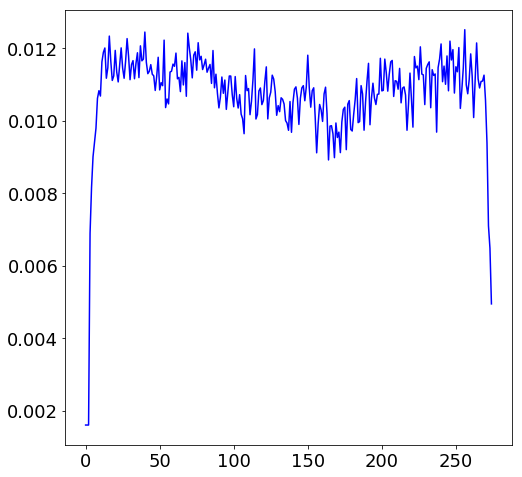

In [556]:
n_coefs = 1
plot(-dot(eig_vec[:,:n_coefs],my_coefs[:n_coefs]))
show()

## svd of raw

In [248]:
my_matrix = array([ones(len(y)),y,x,energy,(x-mean(x))*(energy-mean(energy)),x/fee,x*fee]).transpose()

In [249]:
s,u = eig(dot(my_matrix.transpose(),my_matrix))

In [250]:
v = dot(diag(s),dot(u,my_matrix.transpose()))
v.shape

(7, 173425)

In [298]:
bin_step=0.065
my_bins = arange(-6.0,35,bin_step)
v0_time_probe = []
n_components = 6
for i in arange(n_components):
    v0_time_probe.append( nan_to_num(binned_statistic_dd(z,v[i],bins=[my_bins],statistic=median).statistic))
    
v0_time_probe = array(v0_time_probe)

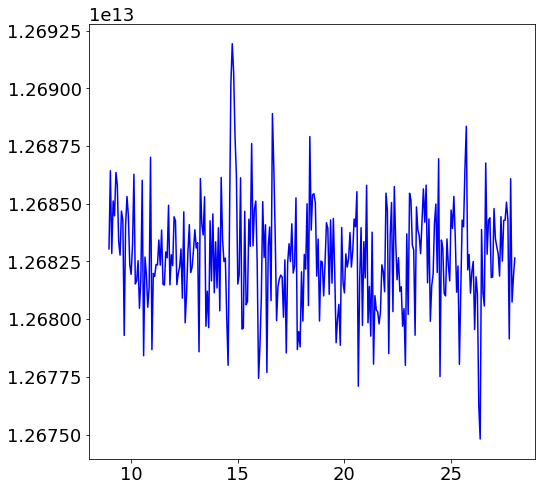

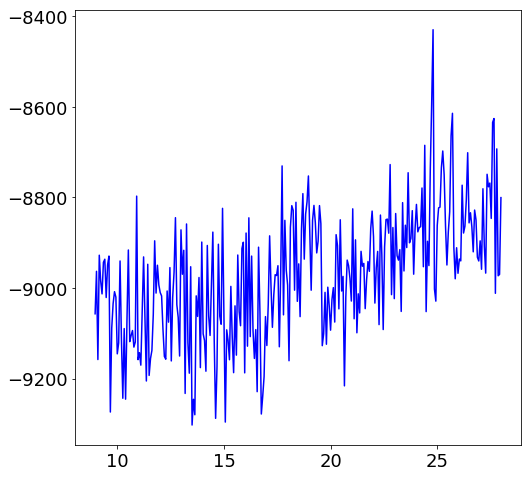

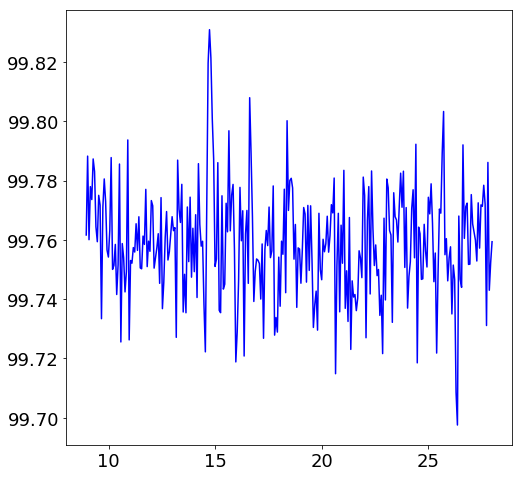

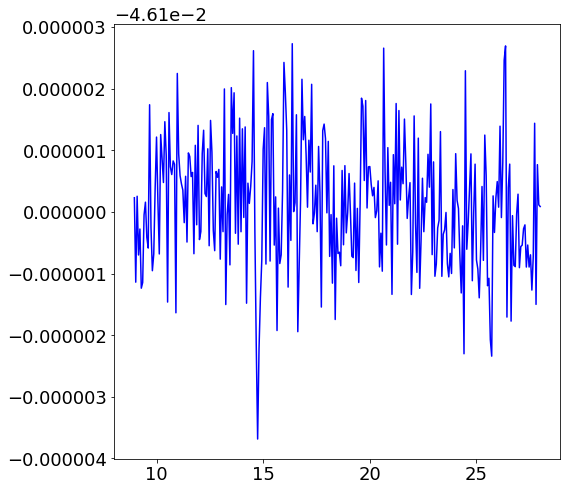

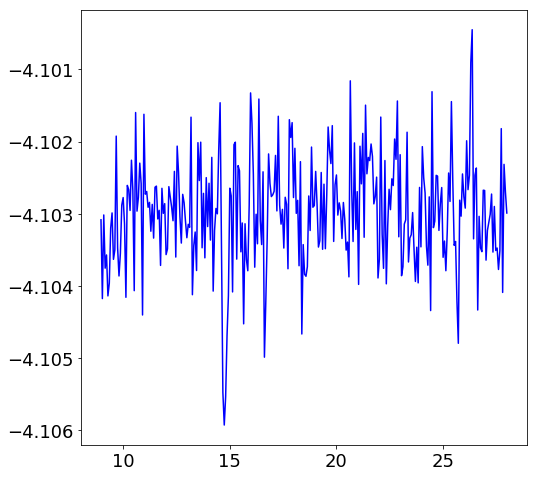

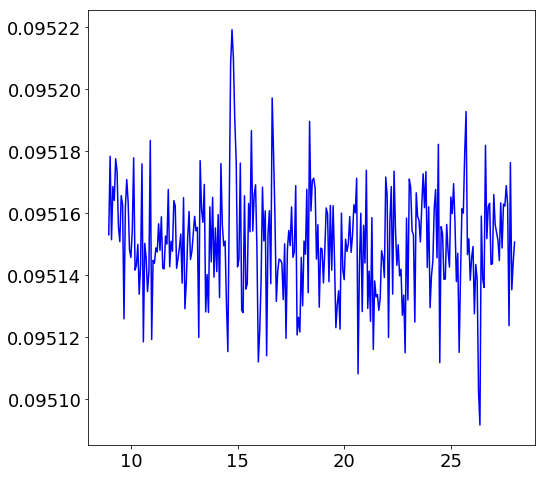

In [299]:
corrected_bins = my_bins[:-1][::-1]

temp_mask = corrected_bins>8.9
temp_mask = temp_mask*(corrected_bins<28)
for i in arange(n_components):
    plot(corrected_bins[temp_mask],v0_time_probe[i][temp_mask])
    show()


In [300]:
ica = FastICA(n_components=5)
S_ = ica.fit_transform(v0_time_probe[:,temp_mask])  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/deeplearning/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


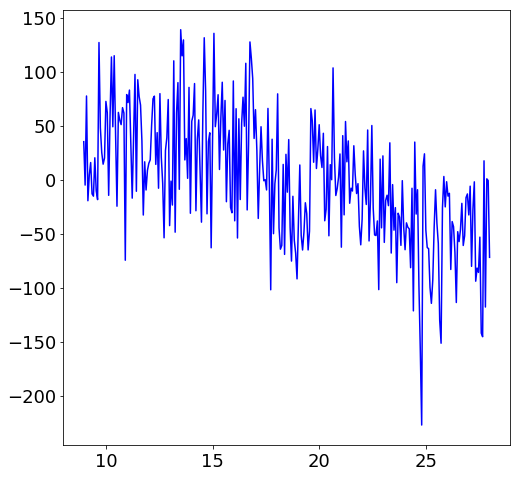

In [301]:
plot(corrected_bins[temp_mask],A_[:,2])

In [302]:
pca = PCA(n_components=6)
H = pca.fit_transform(v0_time_probe[:,temp_mask].transpose())  # Reconstruct signals based on orthogonal components

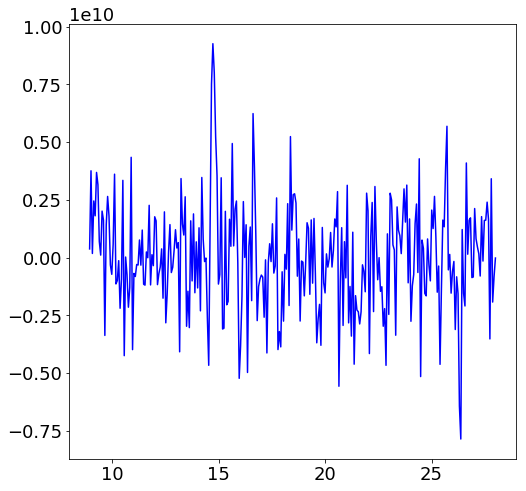

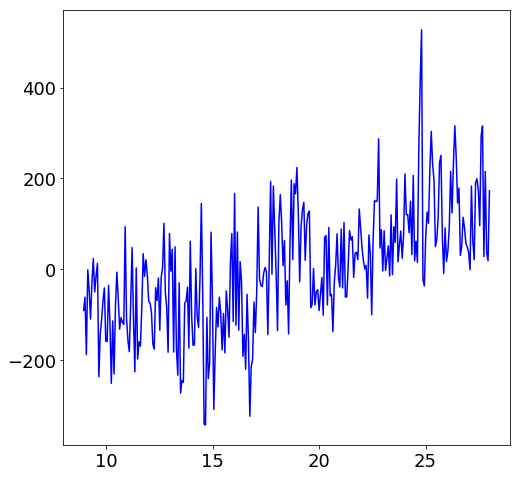

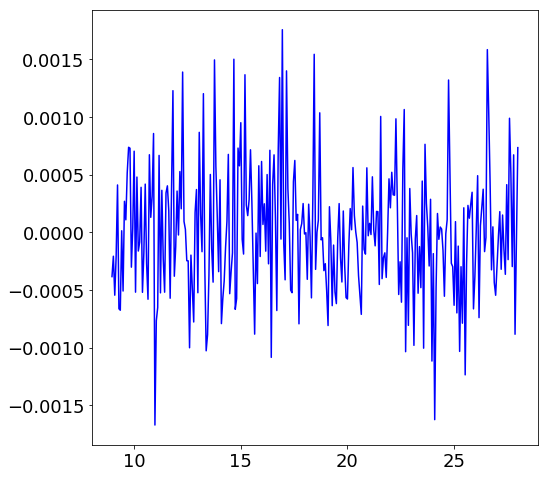

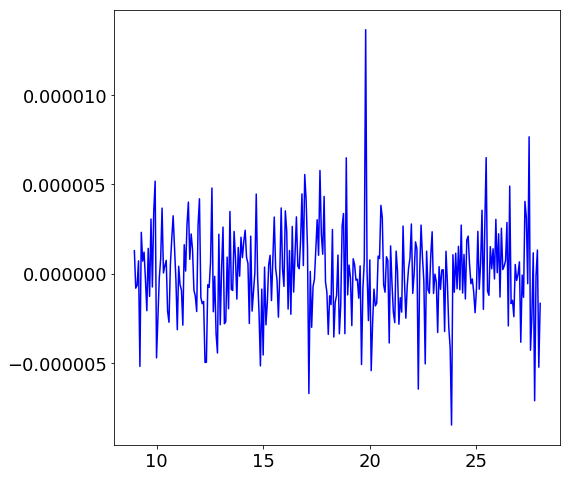

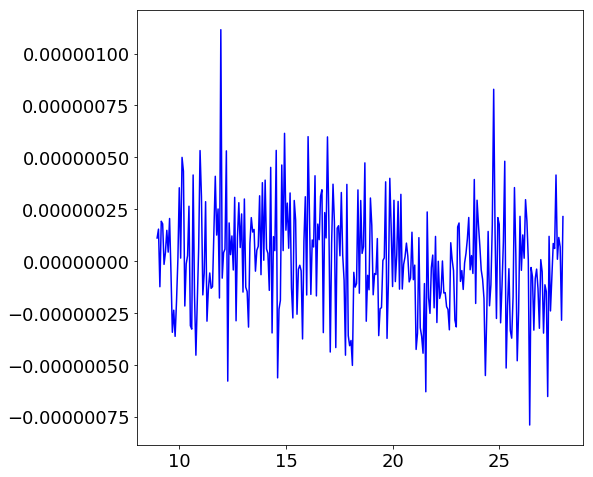

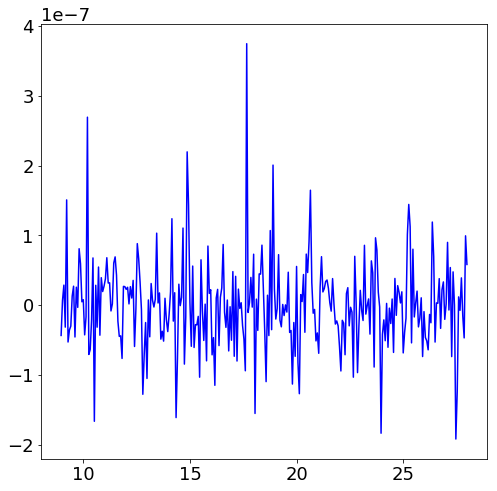

In [303]:
for i in arange(H.shape[1]):
    plot(corrected_bins[temp_mask],H[:,i])
    show()

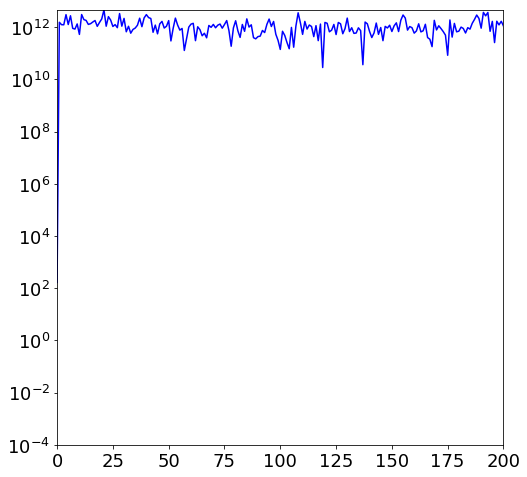

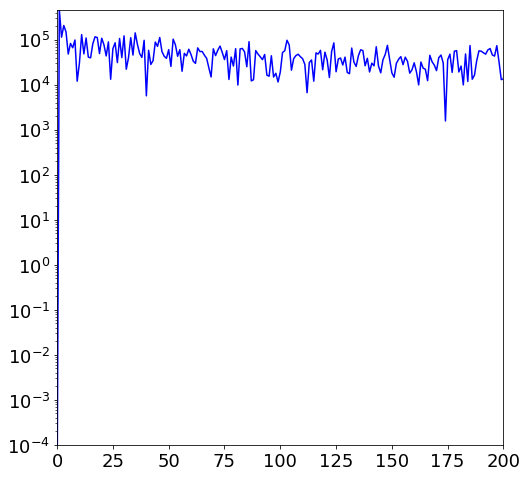

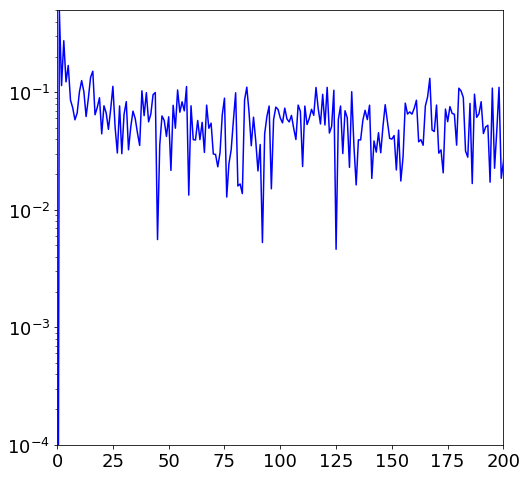

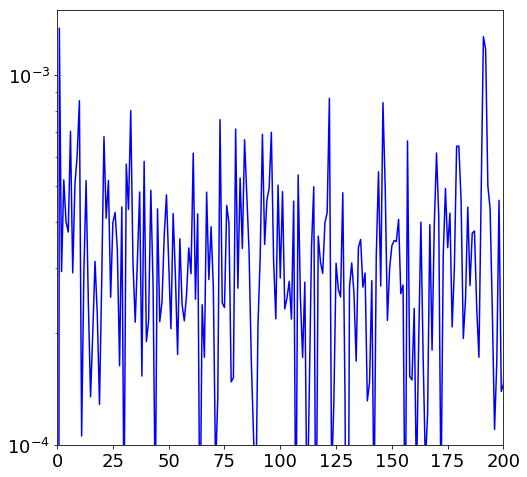

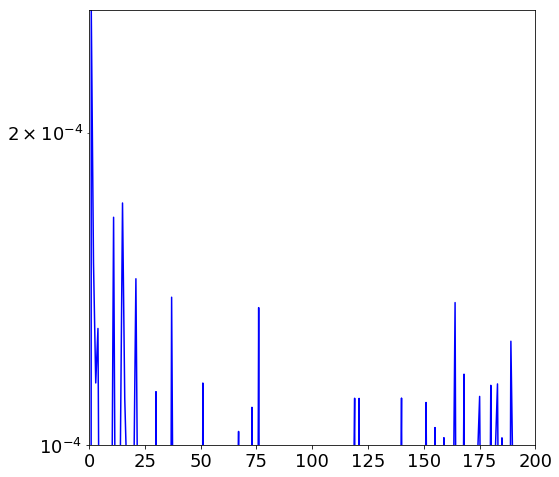

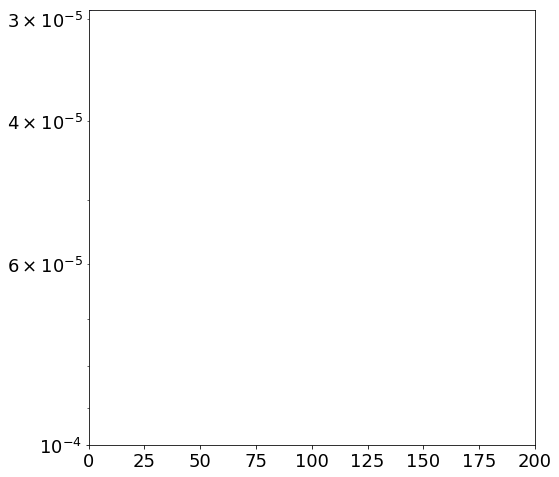

In [297]:
for i in arange(H.shape[1]):
    semilogy(abs(fft(H[:,i])))
    ylim(1e-4,max(abs(fft(H[:,i]))))
    xlim(0,200)
    show()